# Error Propagation in the calculation of SFRD

It is important to propagate uncertainties in the $M^*$, $\phi^*$ and $\alpha$ properly in final computed star formation rate density. We used Monte-Carlo methods to achieve this goal. We generate a random normal distribution of each parameters around its mean value and standard deviation equal to the uncertainty in the parameter (to reduce the computing time, we are currently using each array of size 50). Later we used this random normal distributions in $M^*$, $\phi^*$ and $\alpha^*$ to calculate the Schechter function (for each combination of values for these parameters from the distribution). Then we integrate the Schechter function accordingly (again, for each combination of values of parameters). Doing so, we would have an array of integration values (each value corresponds to the different Schechter function). We then measure the mean and standard deviation of this array to find the uncertainty in the luminosity density --- once, we got the errors in luminosity density, it is fairly easy to propogate this errors in the calculation of the star formation rate density since the conversion factor ($\kappa$) does not have any uncertainty.

We implement this whole procedure to calculate the Star Formation Rate Density in `sfr` function from `util.py` file. Interested use can visit the same file for the code. In the present notebook, we directly use the `utils.sfr` function to compute SFRD.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as con
import os
import utils as utl

In [2]:
# Redshift
z_bou = np.array([4,5,6,7,8])

# Characteristic absolute magnitude
mst_bou = np.array([-20.98, -20.60, -20.37, -20.14, -20.10])
msterr_bou = np.array([0.10, 0.23, 0.30, 0.26, 0.52])

# Characteristic luminosity
lst_bou = np.array([])
lsterr_bou = np.array([])

for i in range(len(mst_bou)):
    mst1 = np.random.normal(mst_bou[i], msterr_bou[i], 10000)
    lst1 = utl.m_to_l_wave(mst1, 1500)
    lst_bou = np.hstack((lst_bou, np.mean(lst1)))
    lsterr_bou = np.hstack((lsterr_bou, np.std(lst1)))


# Normalisation constant
phi_bou = np.array([1.3, 1.4, 1.4, 0.86, 0.59])*0.001
phierr_bou = np.array([0.2, 0.6, 0.85, 0.545, 0.69])*0.001

# Alpha
alp_bou = np.array([-1.73, -1.79, -1.73, -2.01, -1.91])
alperr_bou = np.array([0.005, 0.12, 0.20, 0.21, 0.32])

# Kappas
sol_lum = (con.L_sun*1e7).value
kap_uv = 2.2e-10/sol_lum
kap_ir = 4.5*10**(-44)

# Range of Luminosities (or absolute magnitudes) used
mags_bou = np.linspace(-24, -13, 1000)
lums_bou = utl.m_to_l_wave(mags_bou, 1500)

#print(np.log10(lst_bou))
#print(np.log10(lsterr_bou))
#print(np.log10(lums_bou))

In [3]:
# SFRD without error propagation
sfrd_wo_errs = np.zeros(z_bou.shape)

for i in range(len(z_bou)):
    sfrd_wo_errs[i] = utl.sfrd_wo_err(lum=lums_bou, lum1=lst_bou[i], phi1=phi_bou[i], alpha=alp_bou[i], kappa=kap_uv, limit=0.03, Auv=0.0)

In [4]:
sfrd_bou, sfrd_err_bou = np.zeros(z_bou.shape), np.zeros(z_bou.shape)

for i in range(len(z_bou)):
    sfrd_bou[i], sfrd_err_bou[i] = utl.sfrd_w_err(lum=lums_bou, lum1=lst_bou[i], lum1err=lsterr_bou[i], phi1=phi_bou[i], phi1err=phierr_bou[i], alpha=alp_bou[i], alphaerr=alperr_bou[i], kappa=kap_uv)

100%|██████████| 10000/10000 [01:39<00:00, 100.04it/s]


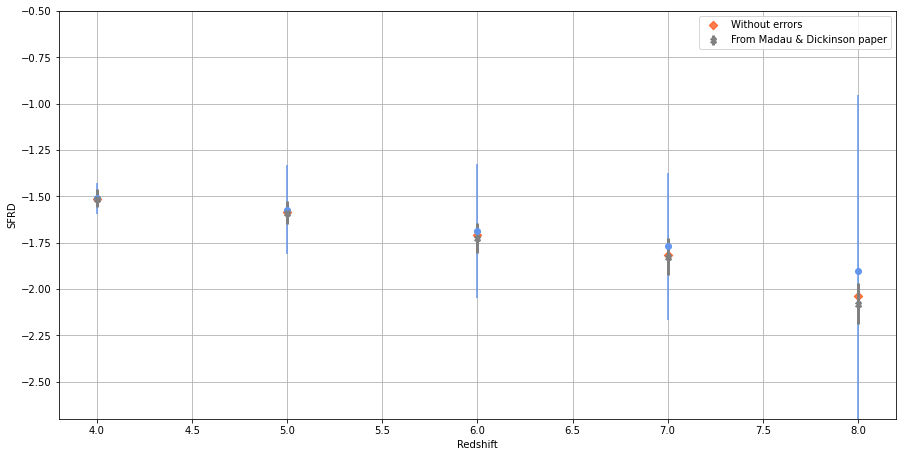

In [5]:
log_sfrd_bou, log_sfrd_bou_err =  utl.log_err(sfrd_bou, sfrd_err_bou)
log_sfrd_wo_bou = np.log10(sfrd_wo_errs)

# Comparing values from Madau&Dickinson paper
z_mad, log_sfrd_mad, log_sfrd_mad_perr, log_sfrd_mad_nerr = np.loadtxt('madau_bou.dat', usecols=(0,1,2,3), unpack=True)

plt.figure(figsize=(15,7.5))
plt.errorbar(z_bou, log_sfrd_bou, yerr=log_sfrd_bou_err, fmt='.', marker='o', c='cornflowerblue')
plt.errorbar(z_mad, log_sfrd_mad, yerr=[log_sfrd_mad_perr, log_sfrd_mad_nerr], marker='X', fmt='.', lw=3, c='grey', label='From Madau & Dickinson paper')
plt.scatter(z_bou, log_sfrd_wo_bou, marker='D', c='orangered', label='Without errors', alpha=0.7)
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.legend(loc='best')
plt.ylim([-2.7, -0.5])
plt.grid()

In [6]:
# Saving all of these values
f23 = open(os.getcwd() + '/Results/Bou12_w_wo.dat','w')
f23.write('#Redshift\tSFRD(wo)\tSFRD(w)\tErr\n')

for i in range(len(sfrd_bou)):
    print('--------------------------------------------------------------------------------')
    print('At redshift {:d}:'.format(z_bou[i]))
    print('Value of SFRD (wo error propagation) is: {:.2e}'.format(sfrd_wo_errs[i]))
    print('Value of log(SFRD) (wo error propagation) is: {:.2e}'.format(log_sfrd_wo_bou[i]))
    print('--------------------------------------------------------------------------------')
    print('Value of SFRD is: {:.2e} +/- {:.2e}'.format(sfrd_bou[i], sfrd_err_bou[i]))
    print('Value of log(SFRD) is: {:.2e} +/- {:.2e}'.format(log_sfrd_bou[i], log_sfrd_bou_err[i]))
    print('--------------------------------------------------------------------------------')
    f23.write(str(z_bou[i]) + '\t' + str(sfrd_wo_errs[i]) + '\t' + str(sfrd_bou[i]) + '\t' + str(sfrd_err_bou[i]) + '\n')
f23.close()

--------------------------------------------------------------------------------
At redshift 4:
Value of SFRD (wo error propagation) is: 3.07e-02
Value of log(SFRD) (wo error propagation) is: -1.51e+00
--------------------------------------------------------------------------------
Value of SFRD is: 3.08e-02 +/- 5.83e-03
Value of log(SFRD) is: -1.51e+00 +/- 8.20e-02
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
At redshift 5:
Value of SFRD (wo error propagation) is: 2.59e-02
Value of log(SFRD) (wo error propagation) is: -1.59e+00
--------------------------------------------------------------------------------
Value of SFRD is: 2.68e-02 +/- 1.48e-02
Value of log(SFRD) is: -1.57e+00 +/- 2.41e-01
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
At redshift 6:
Valu